# Data Exploration
The dataset is explored and some illustrations for a better understanding of the 

In [2]:
# if not already installed, get these packages
##! python -m pip install imutils
##! python -m pip install natsort
##! python -m pip install split-folders

In [1]:
# imports
import cv2
import pandas as pd
import numpy as np
from pathlib import Path
import os
import io
from PIL import Image
import os
from zipfile import ZipFile
import matplotlib.pyplot as plt
import matplotlib
import glob
from natsort import natsorted 
import imutils
from random import randint
import splitfolders
%matplotlib inline 

In [3]:
# Create a ZipFile Object and load sample.zip in it
# Attention: The zip. file was uploaded from my local computer, but the dataset can be found here:#
# https://www.cis.upenn.edu/~jshi/ped_html/

#with ZipFile('./PennFudanPed.zip', 'r') as zipObj:
   # Extract all the contents of zip file in different directory
#    zipObj.extractall('./data')

## Take a look at the data

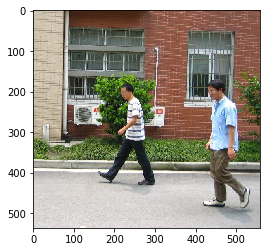

In [4]:
# image location parameters
directory = './data/PennFudanPed/PNGImages'
jpg_image = 'FudanPed00001.png'

# display the selected image
sample_image = Image.open(os.path.join(directory,jpg_image))
plt.imshow(sample_image)

In [3]:
# use DataClass Object to load images
from DataClass import PennFudanDataset
root = './data/PennFudanPed'
data = PennFudanDataset(root, transforms=None)

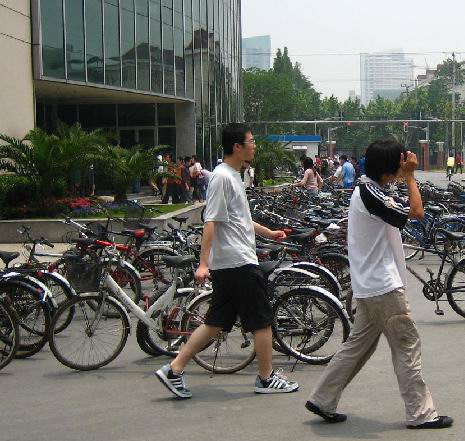

In [6]:
# check if images are loaded ...
data[8]['img']

In [7]:
# set image number for pictures below
image_number = 0

In [8]:
bc = data[image_number]['target']['boxes'].numpy()

./data/PennFudanPed/PNGImages/FudanPed00001.png
<class 'PIL.Image.Image'>


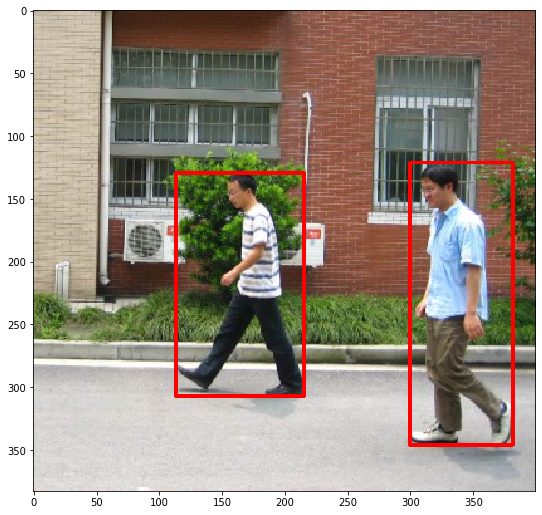

In [9]:
# check if everything works as expected
from helpers import display_bounding_box
print(data[image_number]['img_path'])
display_bounding_box(data[image_number]['img'],data[image_number]['target']['boxes'].numpy(),resize=(400,383))
print(type(data[image_number]['img']))

In [11]:
from helpers import listdir_nohidden, sliding_window, image_pyramid
# create new folder (if it does not exist yet)
Path("./data/movieImages").mkdir(parents=True, exist_ok=True)
# check if folder is empty, if not delete already existing images

if not listdir_nohidden('./data/movieImages'):
    print("Directory is empty")
    print("Saving images into directory 'movieImages' ...")
else:    
    print("Directory is not empty")
    print('Deleting all files in directory movieImages ...')
    filelist = glob.glob(os.path.join('./data/movieImages', "*"))
    for f in filelist:
        os.remove(f)
    print("Saving images into directory 'movieImages' ...")
    


# set parametes for sliding window and initilaize it using the helpers.sliding_window function
height, width, layers = np.array(data[image_number]['img']).shape

height = 112
width  = int(height/2.5)
stride_w = 25
stride_h = 25

# save pictures made for sliding window illustration
imgPyramide = image_pyramid(data[image_number]['img'],minSize=(112,112))
index = 1
for img_pyramide in imgPyramide:
    
    sliding = sliding_window(img_pyramide,window_size=(width,height),step_h=stride_h,step_w=stride_w)

    for slide_img in sliding:
        box_coordinates= np.array([slide_img[0],slide_img[1],slide_img[0]+width,slide_img[1]+height]).reshape((1,4))
        img = display_bounding_box(img_pyramide,box_coordinates,display=False, resize=(400,381))
        plt.imsave(f"./data/movieImages/frame{index}.jpg",img)
        index+=1
        
plt.close('all')
print("Saved all files into directory 'movieImages'. ")



Directory is not empty
Deleting all files in directory movieImages ...
Saving images into directory 'movieImages' ...


KeyboardInterrupt: 

In [10]:
# create video out of saved pictures
height, width, layers = img.shape

out = cv2.VideoWriter('./data/output_video.mp4',cv2.VideoWriter_fourcc(*'VP90'), 40, (width,height))
filenames =[]
print('Creating mp4-video ...')
for filename in glob.glob('./data/movieImages/*.jpg'):
    filenames.append(filename)

filenames = natsorted(filenames)

for filename in filenames:

    img = cv2.imread(filename)
    out.write(img)
    
out.release()
print('Mp4-video was created.')


NameError: name 'img' is not defined

In [14]:
# display video
from IPython.display import Video
Video("./data/output_video.mp4")

## Data Generation
The neural network used later on can only perform a classification task on the images that are substracted by the sliding window approach. 
To re-train the neural network (for feature extraction/fine-tuning), some ground truth are needed that contain whether a pedestrian or not.

For each bounding box that denotes a pedestrian, a piece is cropped out of the image as negative example (i.e. that piece does not contain a pedestrian).

In [4]:
%%time
# create positive samples
# check if directory exists, otherwise create it 
Path("./data/classifierImages/pos_images").mkdir(parents=True, exist_ok=True)
# loop over the images
savedImageCounter=0
for image_number in range(0,len(data)):
    # loop over bounding boxes
    box_counter = 0
    for box in data[image_number]['target']['boxes'].numpy():
        # create an image and save it to the positive samples folder
        pos_image = data[image_number]['img'].crop(tuple(box)).resize((224,int(224*2.5)))
        # save image piece
        plt.imsave(f"./data/classifierImages/pos_images/{image_number}-{box_counter}.jpg",np.array(pos_image))
        savedImageCounter+=1
        box_counter+=1    
print(f"Done. Saved {savedImageCounter} images into './data/classifierImages/pos_images/'.")

Done. Saved 423 images into './data/classifierImages/pos_images/'.
CPU times: user 26.4 s, sys: 1.11 s, total: 27.5 s
Wall time: 14.1 s


In [5]:
%%time
# create negative samples
from helpers import check_neg_boundingBox
# check if directory exists, otherwise create it 
Path("./data/classifierImages/neg_images").mkdir(parents=True, exist_ok=True)
# 
savedImageCounter=0
for image_number in range(0,len(data)):
    
    # get width,height and box coordinates of the image
    height, width , _ = np.array(data[7]['img']).shape
    boxes = data[image_number]['target']['boxes'].numpy()
    
    boxheight= int(height/2)
    boxwidth= int(boxheight/2.5)
    
    counter = 0
    #box scale factor
    bsf = 1
    for number in range(0,3*len(boxes)):
        loop_bool = True  
        while loop_bool:
            counter +=1
            # create two random integers that denote the upper edege of the created box for non-pedestrians
            randIntWidth  = randint(0,width-boxwidth)
            randIntHeight = randint(0,height-boxheight)
         
            success = check_neg_boundingBox(boxes,randIntWidth,randIntHeight,boxwidth/bsf,boxheight/bsf)
            if success:
                # finally crop piece out of image and save it
                neg_image = data[image_number]['img'].crop(tuple((randIntWidth,randIntHeight,randIntWidth+boxwidth/bsf,randIntHeight+boxheight/bsf))).resize((224,int(224*2.5)))
                plt.imsave(f"./data/classifierImages/neg_images/{image_number}-{number}.jpg",np.array(neg_image))
                savedImageCounter+=1
                break
            # increase the box scale factor of no images are found at current scale                           
            #-> this means that boxes always overlap with pedestrian boxes and therfore should be samller 
            if counter> (bsf*75):
                bsf+=1 

            # make sure you dont get stuck in an infinte loop
            if bsf > 5:
                print("Can't find an image piece without an pedestrian...")
                print("Exiting while loop...")
                break
                
print(f"Done. Saved {savedImageCounter} images into './data/classifierImages/neg_images/.'")


Done. Saved 1269 images into './data/classifierImages/neg_images/.'
CPU times: user 1min 35s, sys: 3.57 s, total: 1min 39s
Wall time: 50.7 s


## Prepare for Training, Testing and Validation 
As a final step of the prepeocessing pipeline, the generated images have to be split into train test and validation sets. This can be achieved with the split-folders library.

In [6]:
splitfolders.ratio("./data/classifierImages", output="./data/classifierImages/preparedForTrainTestVal", ratio=(.6, .2, .2), group_prefix=None) 

Copying files: 1692 files [00:00, 1884.20 files/s]


In [7]:
# delte old positive und negative images to free storage (linux)
! rm -r ./data/classifierImages/neg_images
! rm -r ./data/classifierImages/pos_images